# Bicycle Accidents in NYC
Use LM/KNN/Decision Tree/Random Forest regression algorithms from sklearn to predict the accident location.
I will only select a few features I believe are more relevant to accident location. Categorical data will be treated with Pandas get_dummies method. Rows with missing values will be dropped.

Scenario and Data:
NYC is known for its traffic jams. So, going around on a bike is a big time saver. But there’s some risk of having
an accident. We have two datasets to do some research on them:

Bike Stations: https://feeds.citibikenyc.com/stations/stations.json

Vehicle crashes: https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-CollisionsCrashes/h9gi-nx95

Questions:

What is the most dangerous NYC borough / area for a bicycle rider? Use visualization.

What would you change in the locations of bike stations to increase safety? Use visualization.

Where can an accident occur and how close is this from the nearest bike station? Create a predictive
model.

## Step 1. Import libraries

In [1]:
# Import numpy, pandas, matpltlib.pyplot, sklearn modules and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

# Import KNeighborsRegressor from sklearn.neighbors
from sklearn.neighbors import KNeighborsRegressor

# Import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# Import LinearRegression
from sklearn.linear_model import LinearRegression

# Import DecisionTreeRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score

## Step 2. Import Datasets

In [2]:
#NYC collsion data

# import from url
#url = "https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD"
#df = pd.read_csv(url,dtype={'BOROUGH': object})

# import from device
df = pd.read_csv('./Motor_Vehicle_Collisions_-_Crashes.csv',dtype={'BOROUGH': object})

df.info()

/var/folders/z_/jq1p2fjj42lglv5zz6h92d2h0000gn/T/ipykernel_11815/1863357565.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./Motor_Vehicle_Collisions_-_Crashes.csv',dtype={'BOROUGH': object})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1894718 entries, 0 to 1894717
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH DATE                     object 
 1   CRASH TIME                     object 
 2   BOROUGH                        object 
 3   ZIP CODE                       object 
 4   LATITUDE                       float64
 5   LONGITUDE                      float64
 6   LOCATION                       object 
 7   ON STREET NAME                 object 
 8   CROSS STREET NAME              object 
 9   OFF STREET NAME                object 
 10  NUMBER OF PERSONS INJURED      float64
 11  NUMBER OF PERSONS KILLED       float64
 12  NUMBER OF PEDESTRIANS INJURED  int64  
 13  NUMBER OF PEDESTRIANS KILLED   int64  
 14  NUMBER OF CYCLIST INJURED      int64  
 15  NUMBER OF CYCLIST KILLED       int64  
 16  NUMBER OF MOTORIST INJURED     int64  
 17  NUMBER OF MOTORIST KILLED      int64  
 18  CO

In [8]:
#NYC bycicle station data

# import from url
#URL ='https://feeds.citibikenyc.com/stations/stations.json'
#stations = pd.read_json(URL)

# import from device
stations = pd.read_json('./stations.json')

stations = pd.json_normalize(stations.stationBeanList)
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509 entries, 0 to 508
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     509 non-null    int64  
 1   stationName            509 non-null    object 
 2   availableDocks         509 non-null    int64  
 3   totalDocks             509 non-null    int64  
 4   latitude               509 non-null    float64
 5   longitude              509 non-null    float64
 6   statusValue            509 non-null    object 
 7   statusKey              509 non-null    int64  
 8   availableBikes         509 non-null    int64  
 9   stAddress1             509 non-null    object 
 10  stAddress2             509 non-null    object 
 11  city                   509 non-null    object 
 12  postalCode             509 non-null    object 
 13  location               509 non-null    object 
 14  altitude               509 non-null    object 
 15  testSt

## Step 3. Extract year, month, day, hour, weekday

In [9]:
# Convert Start_Time and End_Time to datetypes
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'], errors='coerce')
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'], errors='coerce')

# Extract year, month, day, hour and weekday
df['Year']=df['CRASH DATE'].dt.year
df['Month']=df['CRASH DATE'].dt.strftime('%b')
df['Day']=df['CRASH DATE'].dt.day
df['Hour']=df['CRASH TIME'].dt.hour
df['Weekday']=df['CRASH DATE'].dt.strftime('%a')

##  Step 4. Filtering/Cleaning
### A. Filter accidents involving cyclists

In [10]:
#consider only accidents with at least one cyclist injured or killed
df_bike = df[(df['NUMBER OF CYCLIST INJURED'] > 0) | (df['NUMBER OF CYCLIST KILLED'] > 0)]
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45756 entries, 53 to 1894710
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   CRASH DATE                     45756 non-null  datetime64[ns]
 1   CRASH TIME                     45756 non-null  datetime64[ns]
 2   BOROUGH                        35716 non-null  object        
 3   ZIP CODE                       35715 non-null  object        
 4   LATITUDE                       42351 non-null  float64       
 5   LONGITUDE                      42351 non-null  float64       
 6   LOCATION                       42351 non-null  object        
 7   ON STREET NAME                 39028 non-null  object        
 8   CROSS STREET NAME              32946 non-null  object        
 9   OFF STREET NAME                6659 non-null   object        
 10  NUMBER OF PERSONS INJURED      45754 non-null  float64       
 11  NUMBER OF PE

##  Step 4. Filtering/Cleaning
### B. Filter NANs

In [11]:
df_bike = df_bike[df_bike['BOROUGH'].notna()]
df_bike = df_bike[df_bike['CRASH DATE'].notna()]
df_bike = df_bike[df_bike['CRASH TIME'].notna()]
df_bike = df_bike[df_bike['LATITUDE'].notna()]
df_bike = df_bike[df_bike['LONGITUDE'].notna()]
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34842 entries, 53 to 1894710
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   CRASH DATE                     34842 non-null  datetime64[ns]
 1   CRASH TIME                     34842 non-null  datetime64[ns]
 2   BOROUGH                        34842 non-null  object        
 3   ZIP CODE                       34841 non-null  object        
 4   LATITUDE                       34842 non-null  float64       
 5   LONGITUDE                      34842 non-null  float64       
 6   LOCATION                       34842 non-null  object        
 7   ON STREET NAME                 29122 non-null  object        
 8   CROSS STREET NAME              29121 non-null  object        
 9   OFF STREET NAME                5720 non-null   object        
 10  NUMBER OF PERSONS INJURED      34841 non-null  float64       
 11  NUMBER OF PE

In [12]:
stations = stations[stations['longitude'].notna()]
stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 509 entries, 0 to 508
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     509 non-null    int64  
 1   stationName            509 non-null    object 
 2   availableDocks         509 non-null    int64  
 3   totalDocks             509 non-null    int64  
 4   latitude               509 non-null    float64
 5   longitude              509 non-null    float64
 6   statusValue            509 non-null    object 
 7   statusKey              509 non-null    int64  
 8   availableBikes         509 non-null    int64  
 9   stAddress1             509 non-null    object 
 10  stAddress2             509 non-null    object 
 11  city                   509 non-null    object 
 12  postalCode             509 non-null    object 
 13  location               509 non-null    object 
 14  altitude               509 non-null    object 
 15  testSt

## Step 4. Filtering/Cleaning
### B. Drop Outliers

In [13]:
# Remove outliers for Longitude: n * standard_deviation (n=3)
n=3

median = df_bike['LONGITUDE'].median()
std = df_bike['LONGITUDE'].std()
outliers = (df_bike['LONGITUDE'] - median).abs() > std*n

# Set outliers to NAN
df_bike[outliers] = np.nan

# Remove NAN
df_bike = df_bike[df_bike['LONGITUDE'].notna()]
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34737 entries, 53 to 1894710
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   CRASH DATE                     34737 non-null  datetime64[ns]
 1   CRASH TIME                     34737 non-null  datetime64[ns]
 2   BOROUGH                        34737 non-null  object        
 3   ZIP CODE                       34736 non-null  object        
 4   LATITUDE                       34737 non-null  float64       
 5   LONGITUDE                      34737 non-null  float64       
 6   LOCATION                       34737 non-null  object        
 7   ON STREET NAME                 29044 non-null  object        
 8   CROSS STREET NAME              29043 non-null  object        
 9   OFF STREET NAME                5693 non-null   object        
 10  NUMBER OF PERSONS INJURED      34736 non-null  float64       
 11  NUMBER OF PE

## 5. Plot Number of Bicycles Accident per Borough

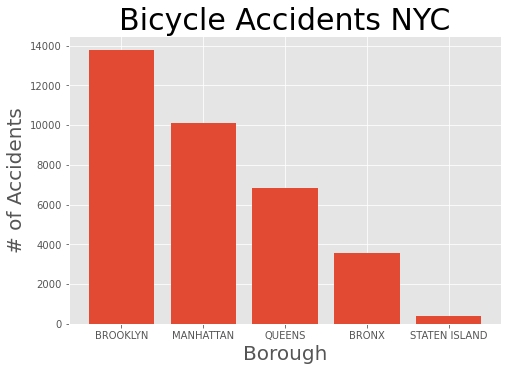

In [14]:
# What is the most dangerous NYC borough / area for a bicycle rider? Use visualization.
# The most dangerous NYC borough is Brooklyn
bar_plot_data = pd.value_counts(np.array(df_bike['BOROUGH']))
bar_plot_data
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
areas = ['BROOKLYN', 'MANHATTAN', 'QUEENS', 'BRONX', 'STATEN ISLAND']
accidents = bar_plot_data
ax.bar(areas,accidents)
# displaying the title
plt.title(label="Bicycle Accidents NYC",
          fontsize=30,
          color="black")
plt.xlabel("Borough",fontsize=20)
plt.ylabel("# of Accidents",fontsize=20)
plt.show()

## 6. Plot Accident & Bike Station Locations

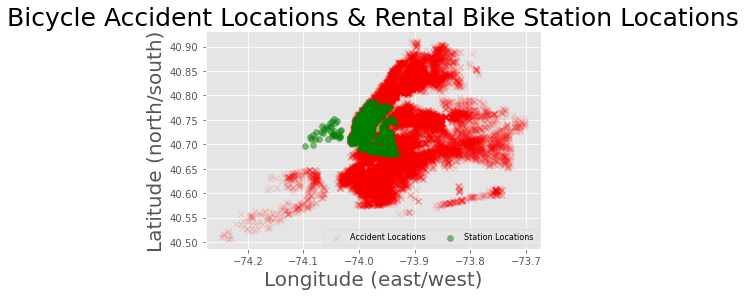

In [71]:
#What would you change in the locations of bike stations to increase safety? Use visualization.

y_acc = df_bike.LATITUDE
x_acc = df_bike.LONGITUDE

y = stations.latitude
x = stations.longitude

acc = plt.scatter(x_acc, y_acc, alpha=0.1, marker='x', color='red')
stat = plt.scatter(x, y, alpha=0.5, marker='o', color='green')

plt.legend((acc, stat),
           ('Accident Locations', 'Station Locations'),
           scatterpoints=1,
           loc='lower right',
           ncol=3,
           fontsize=8)

# displaying the title
plt.title(label="Bicycle Accident Locations & Rental Bike Station Locations",
          fontsize=25,
          color="black")
plt.xlabel("Longitude (east/west)",fontsize=20)
plt.ylabel("Latitude (north/south)",fontsize=20)

plt.show()

## 7. Plot Bike Station Locations

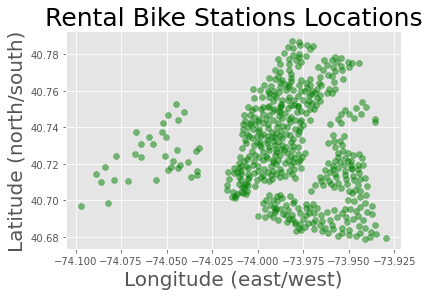

In [17]:
#What would you change in the locations of bike stations to increase safety? Use visualization.
#Move more bike stations to locations with no accidents happening nearby 
# e.g., Lat|Long = 40.69:40.75|-74.025:-74.100 -> More stations on Staten Island less in Brooklyn
stat=plt.scatter(x, y, color = 'green',alpha=0.5)

# displaying the title
plt.title(label="Rental Bike Stations Locations",
          fontsize=25,
          color="black")
plt.xlabel("Longitude (east/west)",fontsize=20)
plt.ylabel("Latitude (north/south)",fontsize=20)


plt.show()

## Step 8. Select a List of Features for Machine Learning Algorithms

In [22]:
# Set the list of features to include in Machine Learning
feature_lst=['BOROUGH','LATITUDE','LONGITUDE','NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','CONTRIBUTING FACTOR VEHICLE 1','CONTRIBUTING FACTOR VEHICLE 2', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2','Hour','Weekday']

In [23]:
# Select the dataset to include only the selected features
df_sel=df_bike[feature_lst].copy()
df_sel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34737 entries, 53 to 1894710
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   BOROUGH                        34737 non-null  object 
 1   LATITUDE                       34737 non-null  float64
 2   LONGITUDE                      34737 non-null  float64
 3   NUMBER OF PERSONS INJURED      34736 non-null  float64
 4   NUMBER OF PERSONS KILLED       34736 non-null  float64
 5   CONTRIBUTING FACTOR VEHICLE 1  34722 non-null  object 
 6   CONTRIBUTING FACTOR VEHICLE 2  32685 non-null  object 
 7   VEHICLE TYPE CODE 1            34720 non-null  object 
 8   VEHICLE TYPE CODE 2            32057 non-null  object 
 9   Hour                           34737 non-null  float64
 10  Weekday                        34737 non-null  object 
dtypes: float64(5), object(6)
memory usage: 3.2+ MB


## Step 9. Drop Rows with Missing Values

In [24]:
# Check missing values
df_sel.isnull().mean()

BOROUGH                          0.000000
LATITUDE                         0.000000
LONGITUDE                        0.000000
NUMBER OF PERSONS INJURED        0.000029
NUMBER OF PERSONS KILLED         0.000029
CONTRIBUTING FACTOR VEHICLE 1    0.000432
CONTRIBUTING FACTOR VEHICLE 2    0.059072
VEHICLE TYPE CODE 1              0.000489
VEHICLE TYPE CODE 2              0.077151
Hour                             0.000000
Weekday                          0.000000
dtype: float64

In [25]:
df_sel.dropna(subset=df_sel.columns[df_sel.isnull().mean()!=0], how='any', axis=0, inplace=True)
df_sel.shape

(31451, 11)

In [26]:
# Check missing values
df_sel.isnull().mean()

BOROUGH                          0.0
LATITUDE                         0.0
LONGITUDE                        0.0
NUMBER OF PERSONS INJURED        0.0
NUMBER OF PERSONS KILLED         0.0
CONTRIBUTING FACTOR VEHICLE 1    0.0
CONTRIBUTING FACTOR VEHICLE 2    0.0
VEHICLE TYPE CODE 1              0.0
VEHICLE TYPE CODE 2              0.0
Hour                             0.0
Weekday                          0.0
dtype: float64

## Step 10. Deal with Categorical Data: pd.get_dummies()

In [27]:
# Generate dummies for categorical data
df_bike_dummy = pd.get_dummies(df_bike,drop_first=True)

df_bike_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34737 entries, 53 to 1894710
Columns: 36593 entries, CRASH DATE to Weekday_Wed
dtypes: datetime64[ns](2), float64(14), uint8(36577)
memory usage: 1.2 GB


In [28]:
# Generate dummies for categorical data
df_sel_dummy = pd.get_dummies(df_sel,drop_first=True)

df_sel_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31451 entries, 53 to 1894710
Columns: 277 entries, LATITUDE to Weekday_Wed
dtypes: float64(5), uint8(272)
memory usage: 9.6 MB


In [172]:
# Export data
#df_bike_dummy.to_csv('./Motor_Vehicle_Collisions_-_Crashes_bike_dummy.csv',index=False)
#df_sel_dummy.to_csv('./Motor_Vehicle_Collisions_-_Crashes_sel_dummy.csv',index=False)

## Step 11. Predict the Accident Location with Various Supervised Machine Learning Algorithms
### Data Preparation: train_test_split

In [41]:
# Assign the data
#df_bike_dummy = df_bike_dummy.drop('CRASH TIME', 1)
#df = df_bike_dummy

#Reduction of dataset due to resource limitations of device in use.
df = df_sel_dummy


# Set the target for the prediction
target = ['LATITUDE','LONGITUDE']


# Create arrays for the features and the response variable

# set X and y
y = df[target]
X = df.drop(target, axis=1)

In [42]:
# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify = None)

In [43]:
# List of classification algorithms
algo_lst=['Linear Regression',' K-Nearest Neighbors Regression','Decision Trees Regression','Random Forest Regression']

# Initialize an empty list for the r-squared metric for each algorithm
r2_lst=[]

## Step 11. Predict the Accident Location with Various Supervised Machine Learning Algorithms
### Algorithm A. Linear Regression

In [44]:
# Linear Regression
lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred = lm.predict(X_test)

# Get the accuracy score
r2=r2_score(y_test, y_pred)

# Append to the accuracy list
r2_lst.append(r2)

print("[Linear regression algorithm] r2_score: {:.3f}.".format(r2))

[Linear regression algorithm] r2_score: 0.695.


## Step 11. Predict the Accident Location with Various Supervised Machine Learning Algorithms
### Algorithm B. k-Nearest Neighbors

In [45]:
from sklearn.neighbors import KNeighborsRegressor
# k-Nearest Neighbors Regression
knr = KNeighborsRegressor()
knr.fit(X_train,y_train)
y_pred = knr.predict(X_test)

# Get the accuracy score
r2=r2_score(y_test, y_pred)

# Append to the accuracy list
r2_lst.append(r2)

print("[k-Nearest Neighbors Regression algorithm] r2_score: {:.3f}.".format(r2))

[k-Nearest Neighbors Regression algorithm] r2_score: 0.420.


## Step 11. Predict the Accident Location with Various Supervised Machine Learning Algorithms
### Algorithm C. Decision Tree

In [46]:
# decision tree for multioutput regression
dtr = DecisionTreeRegressor()
dtr.fit(X_train,y_train)
y_pred = dtr.predict(X_test)

# Get the accuracy score
r2=r2_score(y_test, y_pred)

# Append to the accuracy list
r2_lst.append(r2)

print("[Decision Tree Regression algorithm] r2_score: {:.3f}.".format(r2))

[Decision Tree Regression algorithm] r2_score: 0.466.


## Step 11. Predict the Accident Location with Various Supervised Machine Learning Algorithms
### Algorithm D. Random Forest Regression

In [49]:
# random forest regression
rfr = RandomForestRegressor()
#rfr = RandomForestRegressor(n_estimators=100, max_depth=5)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

# Get the accuracy score
r2=r2_score(y_test, y_pred)

# Append to the accuracy list
r2_lst.append(r2)

print("[Random Forest Regression algorithm] r2_score: {:.3f}.".format(r2))

[Random Forest Regression algorithm] r2_score: 0.647.


## Step 11. Predict the Accident Location with Various Supervised Machine Learning Algorithms
### Algorithm D. Random Forest Regression
#### Visualize important features

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


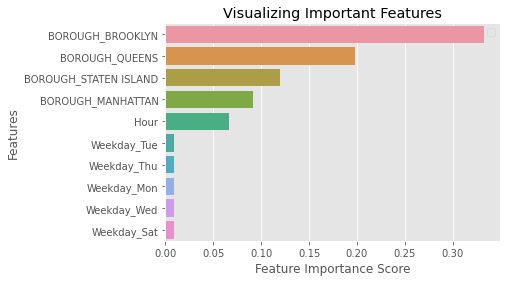

In [50]:
feature_imp = pd.Series(rfr.feature_importances_,index = X.columns).sort_values(ascending = False)

# Creating a bar plot, displaying only the top k features
k=10
sns.barplot(x = feature_imp[:10], y = feature_imp.index[:k])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Step 12. Plot the Predicted Accident & Bike Station Locations
### Use Linear Regression (highest R-squared)

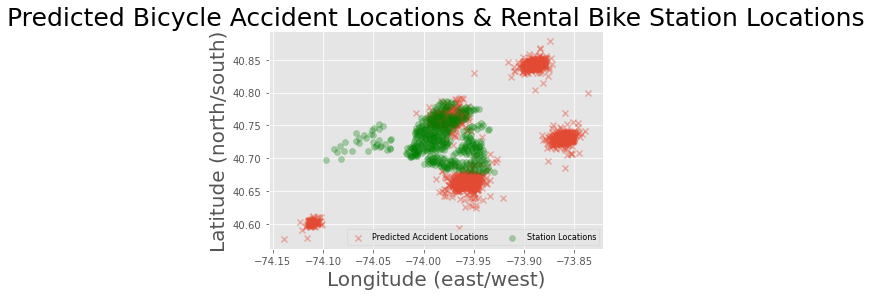

In [70]:
#Where can an accident occur?

y_acc = lm.predict(X_test)[:,0]
x_acc = lm.predict(X_test)[:,1]

y = stations.latitude
x = stations.longitude

pred_acc = plt.scatter(x_acc, y_acc, alpha=0.4, marker='x')
stat = plt.scatter(x, y, color = 'green',alpha=0.3)

plt.legend((pred_acc, stat),
           ('Predicted Accident Locations', 'Station Locations'),
           scatterpoints=1,
           loc='lower right',
           ncol=3,
           fontsize=8)

# displaying the title
plt.title(label="Predicted Bicycle Accident Locations & Rental Bike Station Locations",
          fontsize=25,
          color="black")
plt.xlabel("Longitude (east/west)",fontsize=20)
plt.ylabel("Latitude (north/south)",fontsize=20)

plt.show()

## Step 13. Distance of Predicted Accidents to Nearest Bike Station

In [53]:
#Where can an accident occur and how close is this from the nearest bike station? 

In [54]:
# Initialize an empty list for min distance of predicted locations to nearest bike station
Row_min_dist_lst=[]
for i in range(0, y_acc.size):
    #substract all station lat and long coordinate from the predicted accident location
    disty = np.repeat(y_acc[i], y.size, axis=0)-y
    distx = np.repeat(x_acc[i], x.size, axis=0)-x
    #calculate the euclidian distance of all accident station pairs
    dist = np.sqrt(np.square(distx) + np.square(disty))
    #find the smallest distance = nearest station
    min_dist = min(dist)
    df = pd.DataFrame(dist)
    #locate the Row for the correspoding station dataset to identify the nearest station
    Row_min = df.loc[df[0] == min_dist]
    #write the identified Row in a list
    Row_min_dist_lst.append(Row_min.index)
    #repeat for all predicted accident locations

In [55]:
#identifiy the station names and coordinates of the repsective nearest station
nearest_stationName_lst=[]
nearest_station_lat_lst=[]
nearest_station_long_lst=[]
for i in range(0, y_acc.size):
    Names = stations["stationName"][Row_min_dist_lst[i]]
    nearest_stationName_lst.append(Names)
    lat = stations["latitude"][Row_min_dist_lst[i]]
    nearest_station_lat_lst.append(lat)
    long = stations["longitude"][Row_min_dist_lst[i]]
    nearest_station_long_lst.append(long)

In [56]:
nearest_stationName = np.array(nearest_stationName_lst)
nearest_station_lat = np.array(nearest_station_lat_lst)
nearest_station_long = np.array(nearest_station_long_lst)

## Step 14. Plot the Predicted Accident & Nearest Bike Station Locations
### Use Linear Regression (highest R-squared)

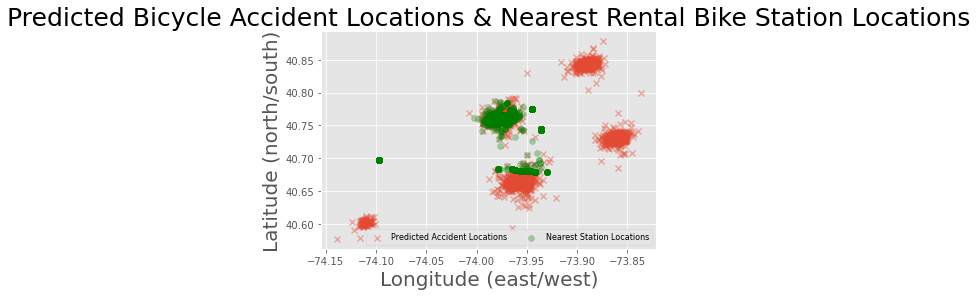

In [67]:
#Where can an accident occur and how close is this from the nearest bike station? 
y_acc = lm.predict(X_test)[:,0]
x_acc = lm.predict(X_test)[:,1]

y = nearest_station_lat
x = nearest_station_long

pred_acc = plt.scatter(x_acc, y_acc, alpha=0.4, marker='x')
near_stat = plt.scatter(x, y, color = 'green',alpha=0.3)


plt.legend((pred_acc, stat),
           ('Predicted Accident Locations', 'Nearest Station Locations'),
           scatterpoints=1,
           loc='lower right',
           ncol=3,
           fontsize=8)

# displaying the title
plt.title(label="Predicted Bicycle Accident Locations & Nearest Rental Bike Station Locations",
          fontsize=25,
          color="black")
plt.xlabel("Longitude (east/west)",fontsize=20)
plt.ylabel("Latitude (north/south)",fontsize=20)

plt.show()